## Time to get your hands dirty! Supernova distances and redshifts (part 2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from astropy.cosmology import FlatLambdaCDM

from astroML import stats as astroMLstats

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import scipy

import corner

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[7,5]

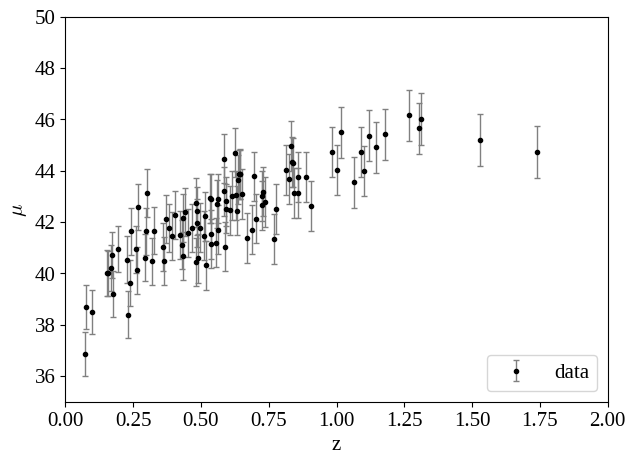

In [3]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

i_ord=z_sample.argsort()

z_sample=z_sample[i_ord]
mu_sample=mu_sample[i_ord]
dmu=dmu[i_ord]

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

### GPR

Fit the data using the Gaussian Process Regressor.

In [4]:
z_grid=np.linspace(0.01, 2, 100)

kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-5, 1e5))

gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2)

gaussian_process.fit(z_sample[:,np.newaxis], mu_sample[:,np.newaxis])
mean_prediction, std_prediction = gaussian_process.predict(z_grid[:,np.newaxis], return_std=True)

print(gaussian_process.kernel_)

30.7**2 * RBF(length_scale=3.9)


Gaussian Process Regressor optimize by itself the hyperparameters of the fit

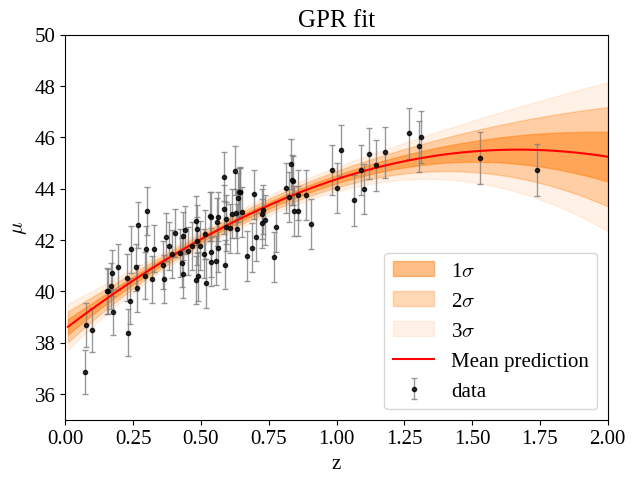

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data', alpha=0.8)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

plt.fill_between(z_grid.ravel(), mean_prediction - 1 * std_prediction, 
    mean_prediction + 1 * std_prediction, color="tab:orange", alpha=0.5, label='1$\sigma$')
plt.fill_between(z_grid.ravel(), mean_prediction - 2 * std_prediction, 
    mean_prediction + 2 * std_prediction, color="tab:orange", alpha=0.3, label='2$\sigma$')
plt.fill_between(z_grid.ravel(), mean_prediction - 3 * std_prediction, 
    mean_prediction + 3 * std_prediction, color="tab:orange", alpha=0.1, label='3$\sigma$')

plt.plot(z_grid, mean_prediction, label="Mean prediction", c='red')

plt.title('GPR fit')
plt.legend(loc='lower right')
plt.show()

The fit present the minimum of the variance at lower redshift, below $z\simeq 1.2$. This because in this range we have the majority of the data. At higher redshift, where the amount of data decreases, the variance of the fit increases; this agrees with the expectations.

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

### Theoretical model

We can obtain the theoretical $\Lambda$CDM model from `Astropy`.

In [6]:
# Model
def model(par, z):
    H0, Om = par
    
    # Flat universe model
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted

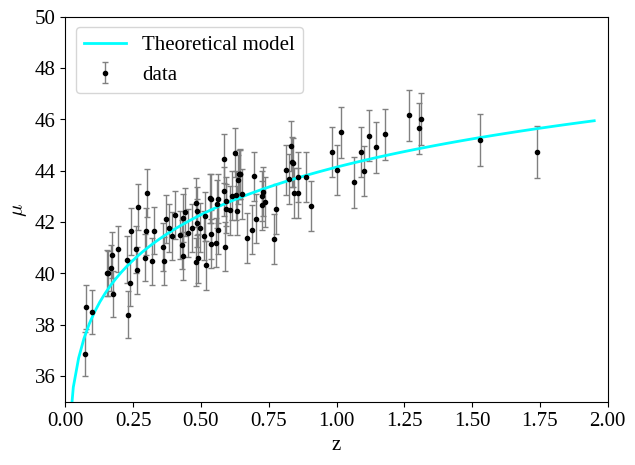

In [7]:
# Theoretical model
zgrid = np.linspace(0.01,1.95,100)
p0 = [70, 0.27]
true_model = model(p0, zgrid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

plt.plot(zgrid, true_model, c='Cyan', lw=2, label='Theoretical model')

plt.legend()
plt.show()

### Nested sampling

We have now a model, which depends on 2 parameters, and the data. We can try to use a nested sampling algorithm to fit our model to the data, and obtain the posterior istributions of the parameters. 

In [8]:
# try to use nested sampling to obtain the parameters

ndim=2

def prior(u):         
    H0 = u[0]*300         
    Om = u[1]  
    
    par = np.array([H0,Om])   
    return(par)

def loglike(par):
    mufit = model(par, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2)) 

In [9]:
sampler = dynesty.NestedSampler(loglike, prior, ndim)
sampler.run_nested()
result = sampler.results

2504it [00:16, 152.17it/s, +500 | bound: 3 | nc: 1 | ncall: 20641 | eff(%): 14.915 | loglstar:   -inf < -46.387 <    inf | logz: -50.534 +/-  0.076 | dlogz:  0.001 >  0.509]


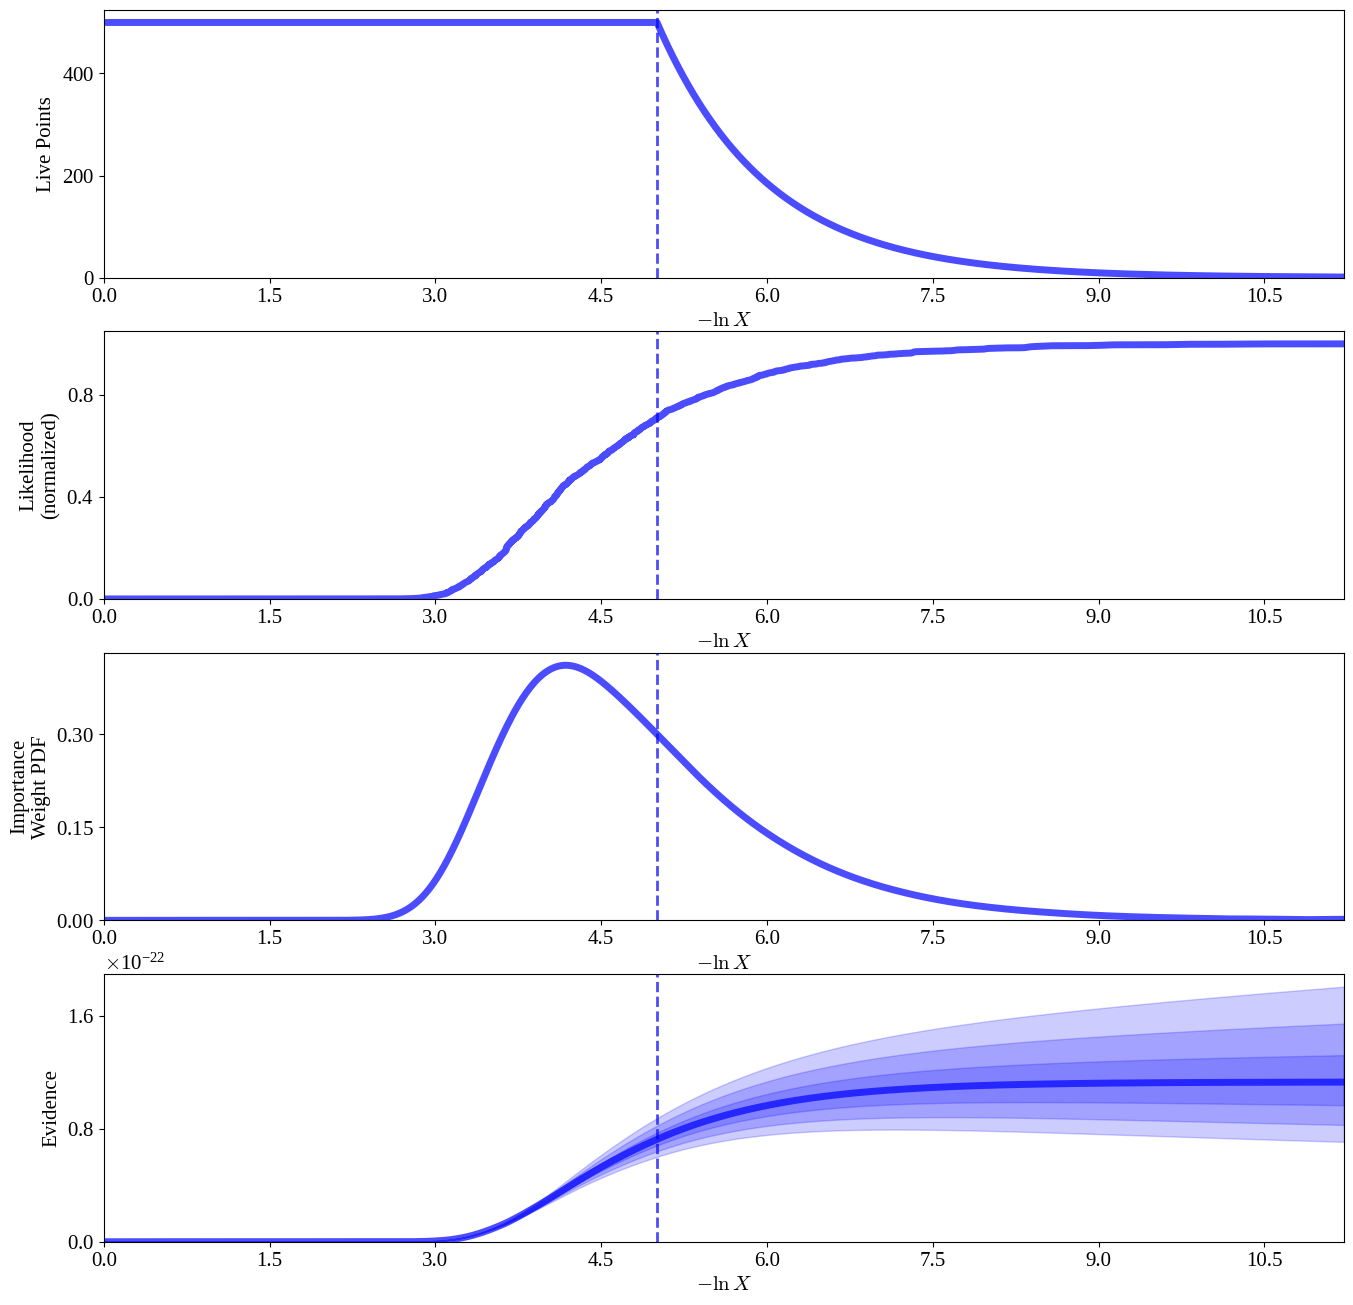

In [10]:
rfig, raxes = dyplot.runplot(result)

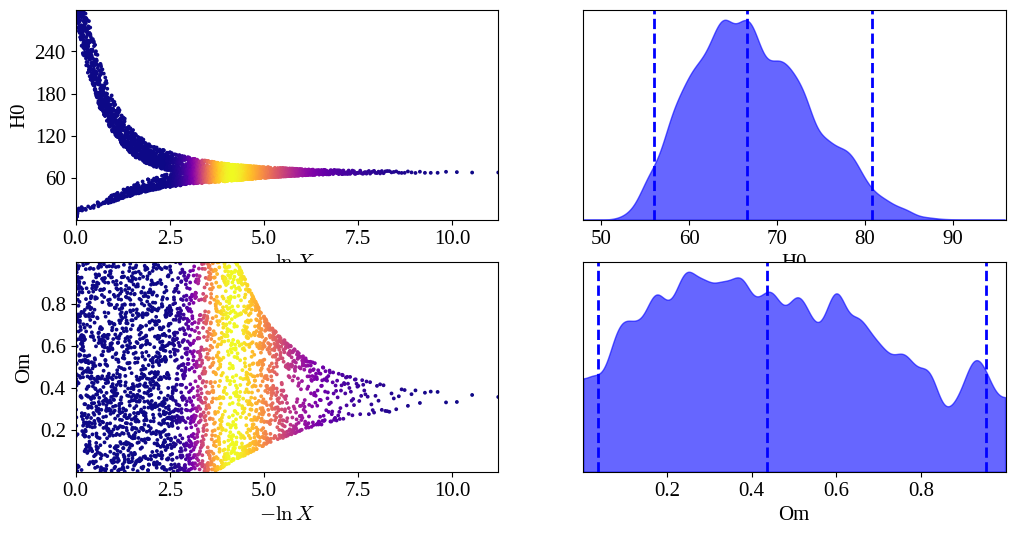

In [11]:
labels = ["H0","Om"]

tfig, taxes = dyplot.traceplot(result, labels=labels)

In [12]:
samples = result.samples
weights = np.exp(result.logwt - result.logz[-1])

samples_eq = dyfunc.resample_equal(samples, weights)

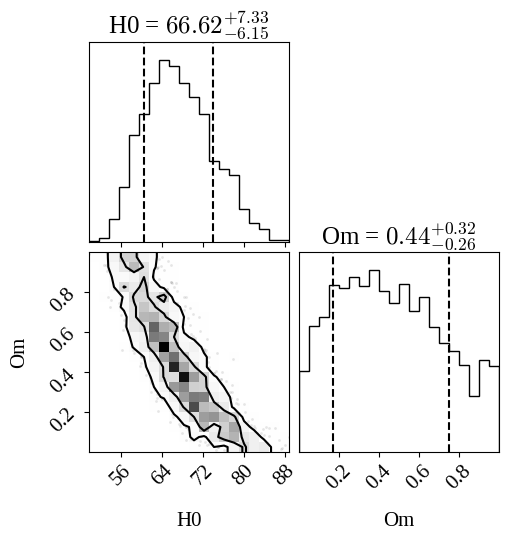

In [13]:
fig = corner.corner(samples_eq, labels=labels, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

The first thing we can observe is that the values of $\Omega_m$ and $H_0$ are correlated. But the results that we obtained for the parameters present high errors, in particular for $\Omega_m$.

In [14]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

H0 = 66.6 + 12.27 - 9.12
Om = 0.44 + 0.49 - 0.36


Let's have a look at the posterior spread of the model.

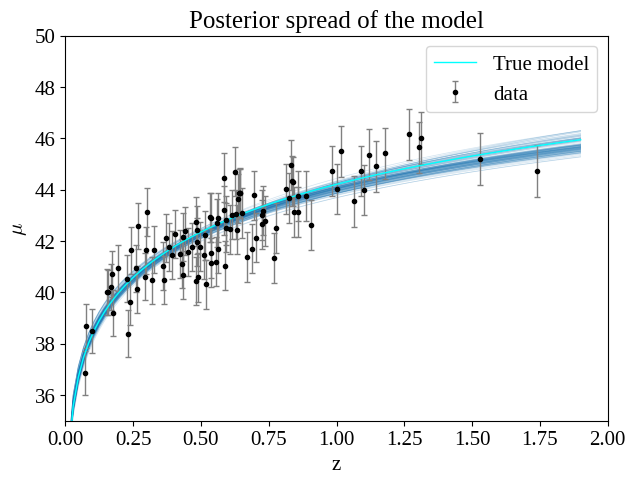

In [15]:
sample100 = samples_eq[np.random.choice(range(len(samples_eq)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for H0, Om in sample100:
    par = [H0, Om]
    model_spread = model(par, zgrid)
    plt.plot(zgrid, model_spread, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

It seems that the model fit well the data, despite the high uncertanties.

We can try now to consider a model without dark energy, to verify if the data contain evidence of this element.

In [16]:
# Model

ndim_noDE=1

def model_noDE(H0, Om, z):
    cosmo = FlatLambdaCDM(H0=H0, Om0=1)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


def prior_noDE(u):
    H0 = u[0]*300  
    
    par = np.array([H0])   
    return(par)


def loglike_noDE(par):

    H0 = float(par)    
    Om=1
    mufit = model_noDE(H0, Om, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2))

In [17]:
sampler_noDE = dynesty.NestedSampler(loglike_noDE, prior_noDE, ndim_noDE)
sampler_noDE.run_nested()
result_noDE = sampler_noDE.results

2349it [00:13, 168.21it/s, +500 | bound: 2 | nc: 1 | ncall: 19083 | eff(%): 15.331 | loglstar:   -inf < -47.102 <    inf | logz: -50.895 +/-  0.067 | dlogz:  0.001 >  0.509]


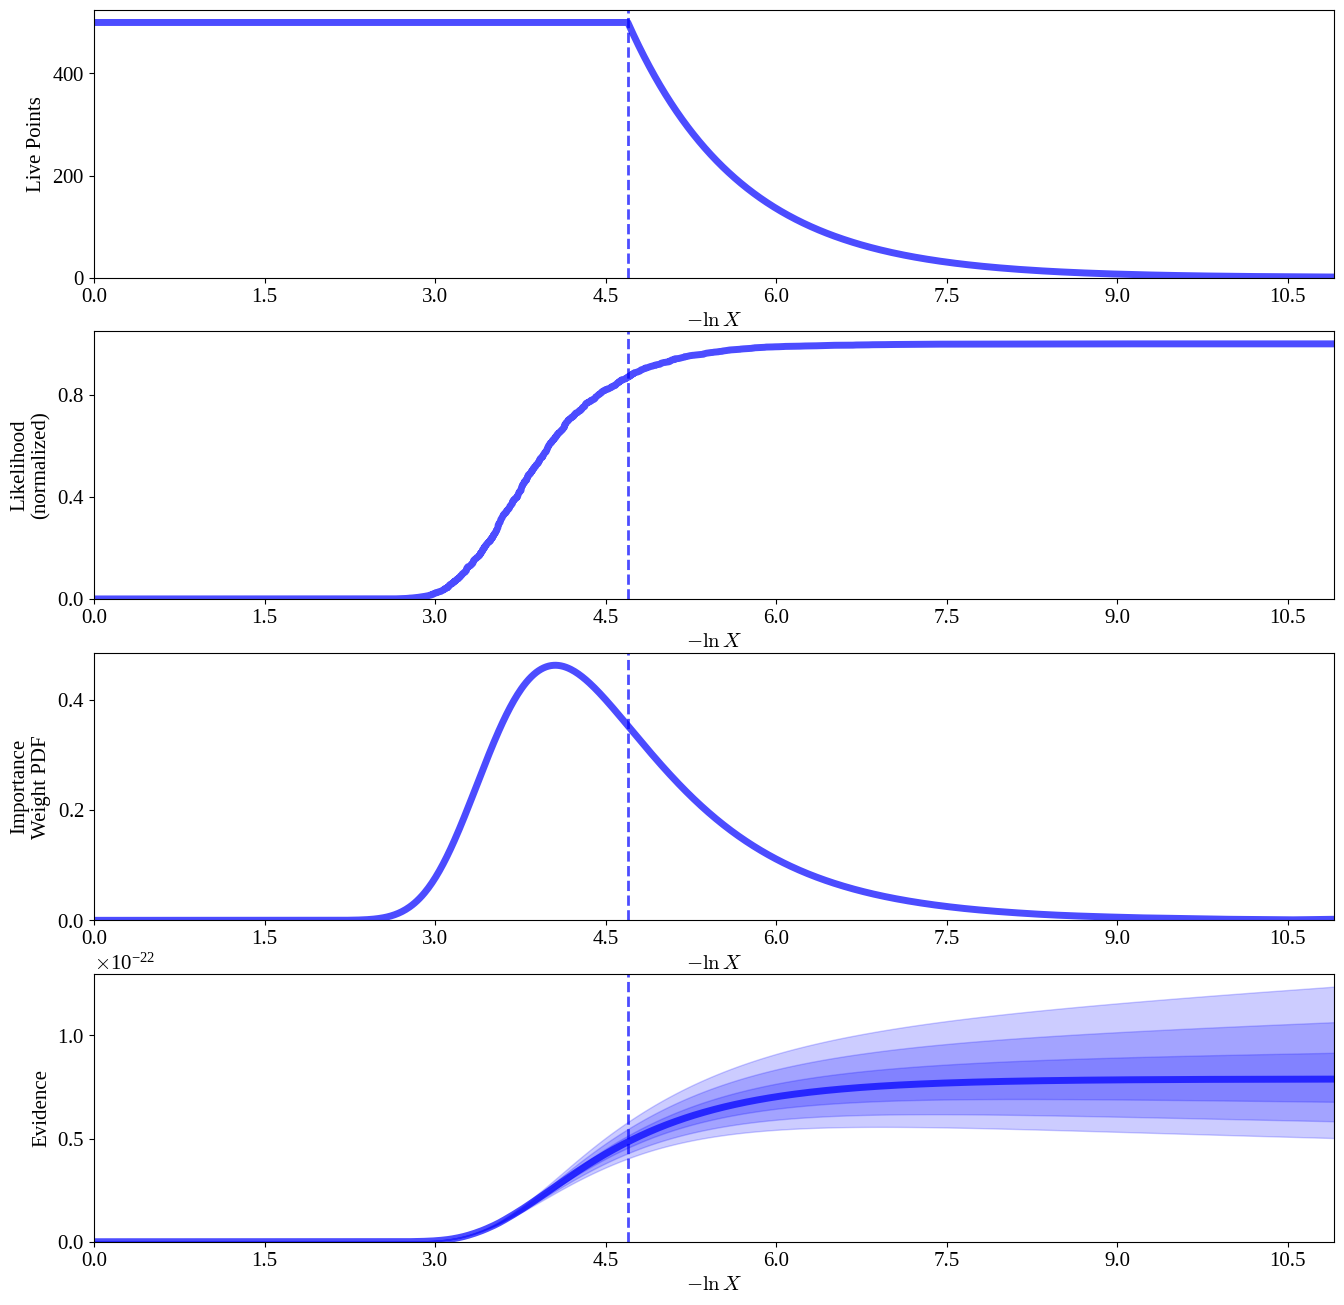

In [18]:
rfig, raxes = dyplot.runplot(result_noDE)

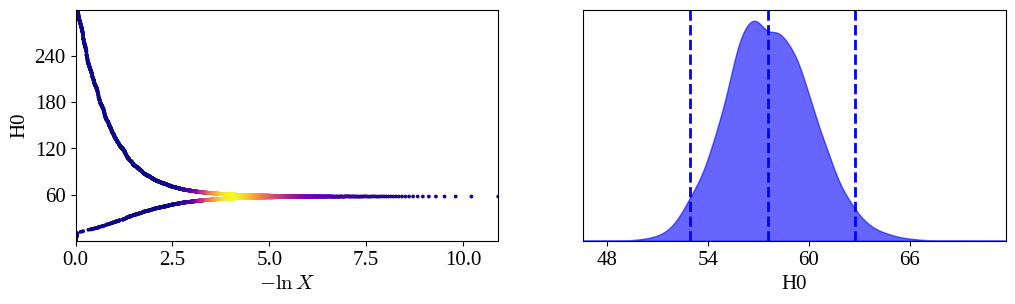

In [19]:
labels_noDE = ["H0"]

tfig, taxes = dyplot.traceplot(result_noDE, labels=labels_noDE)

In [20]:
samples_noDE = result_noDE.samples
weights_noDE = np.exp(result_noDE.logwt - result_noDE.logz[-1])

samples_eq_noDE = dyfunc.resample_equal(samples_noDE, weights_noDE)

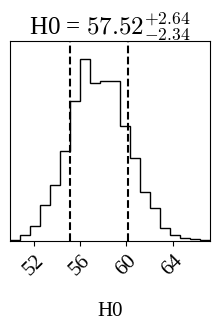

In [21]:
fig = corner.corner(samples_eq_noDE, labels=labels_noDE, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [22]:
quantiles_noDE = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_noDE)
             for samps in samples_noDE.T]
for q,l in zip(quantiles_noDE,labels_noDE):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

H0 = 57.56 + 4.4 - 3.96


The value inferred for $H_0$ is smaller than in the full model, this agrees with the correlation that we found before.

Consider now the posterior spread of the model, to have a visualization of the goodness (or not) of this fit.

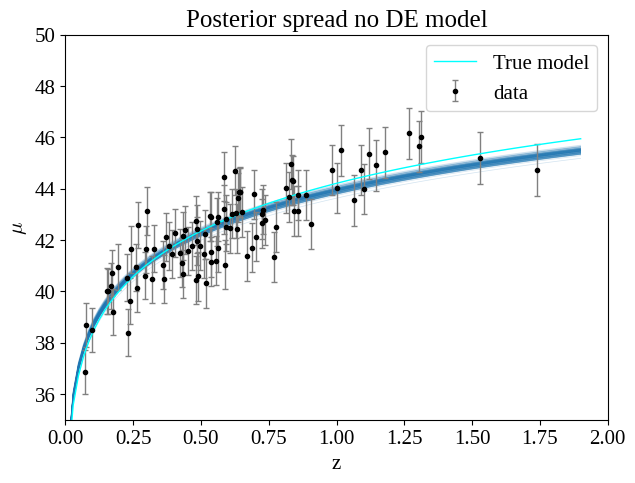

In [23]:
sample100_noDE = samples_eq_noDE[np.random.choice(range(len(samples_eq_noDE)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for H0 in sample100_noDE:
    model_spread_noDE = model_noDE(float(H0), 1, zgrid)
    plt.plot(zgrid, model_spread_noDE, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread no DE model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

Unfortunately it seems that also this model fit quite well the data.

Let's compare the two models, to verifiy if the presence of the dark energy improves the results of the fit.

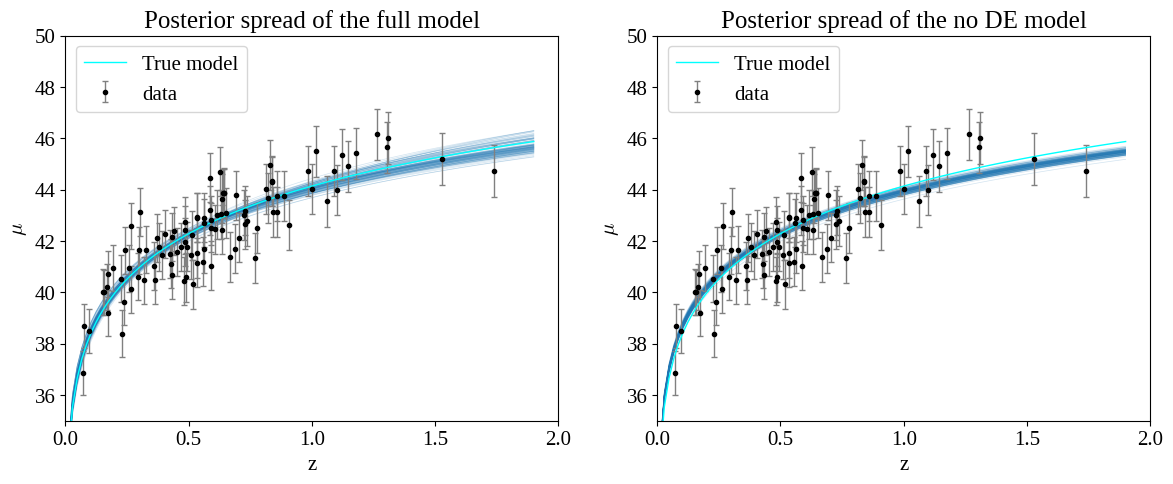

In [24]:
#compare the two models

true_model = model(p0, zgrid)

fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)

for H0, Om in sample100:
    par = [H0, Om]
    model_spread = model(par, zgrid)
    plt.plot(zgrid, model_spread, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the full model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')

plt.legend()

ax = fig.add_subplot(122)

for H0 in sample100_noDE:
    model_spread_noDE = model_noDE(float(H0), 1, zgrid)
    plt.plot(zgrid, model_spread_noDE, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread of the no DE model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

In [25]:
evidence = np.exp(result.logz[-1])
evidence_noDE = np.exp(result_noDE.logz[-1])

Bayes_factor = evidence/evidence_noDE

print(Bayes_factor)

#the Bayes factor is nearly eqaul to 1

1.4348555737714683


The Bayes factor is nearly equal to 1, this means that there is no model that is favored compared to the other. This is a problem, with this dataset we cannot say whether or not there is the presence of dark energy in the universe. But still we have an estimation of the parameters of the two models. 

In this case maybe we can try to improve the results obtained by fixing some parameters. Suppose that we measurd the value of the Hubble constant using a different method (for example cross-correlation between galaxies and gravitational waves events) and we estimate $H_0=70km/s/Mpc$, maybe this result could help to better constrain the value of $\Omega_m$ and so the amount of dark energy in the universe.

In [26]:
#let's imagine that we measured H0=70km/(s*Mpc) and we want to infer the value of Om

# Model

ndim_H0=1

def model_H0(H0, Om, z):
    cosmo = FlatLambdaCDM(H0=70, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


def prior_H0(u):
    Om = u[0]  
    
    par = np.array([Om])   
    return(par)


def loglike_H0(par):

    H0 = 70
    Om = float(par) 
    mufit = model_H0(H0, Om, z_sample)
    return - 0.5 * np.sum((mu_sample-mufit)**2/(dmu**2))

In [27]:
sampler_H0 = dynesty.NestedSampler(loglike_H0, prior_H0, ndim_H0)
sampler_H0.run_nested()
result_H0 = sampler_H0.results

1090it [00:03, 349.26it/s, +500 | bound: 0 | nc: 1 | ncall: 4963 | eff(%): 35.626 | loglstar:   -inf < -46.399 <    inf | logz: -47.676 +/-    nan | dlogz:  0.001 >  0.509]


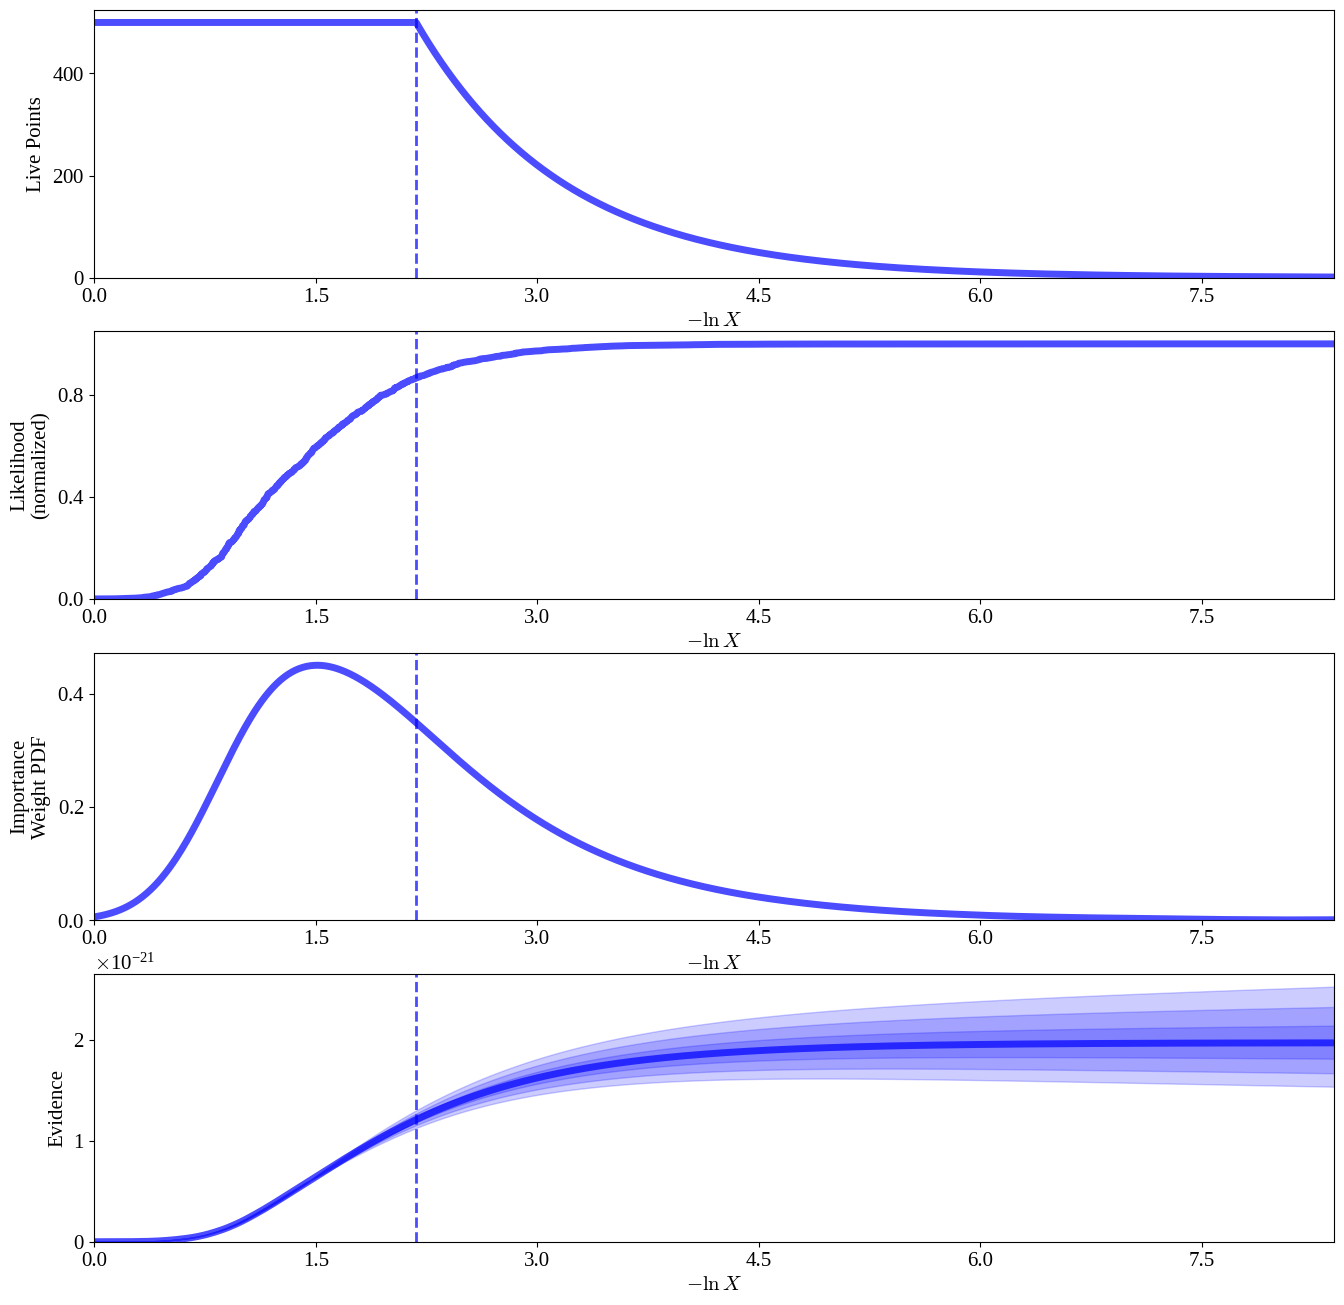

In [28]:
rfig, raxes = dyplot.runplot(result_H0)

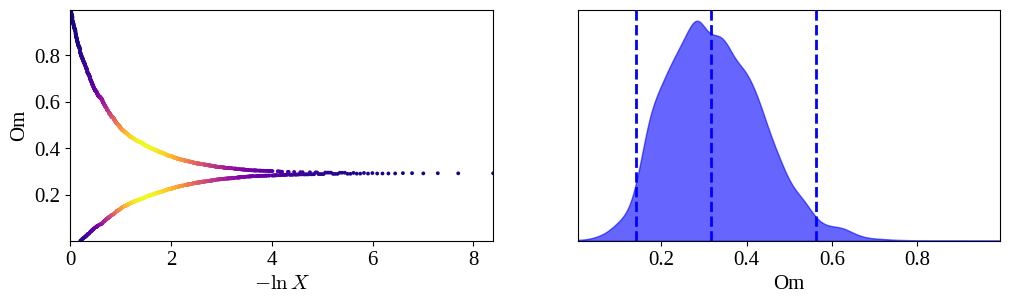

In [29]:
labels_H0 = ["Om"]

tfig, taxes = dyplot.traceplot(result_H0, labels=labels_H0)

In [30]:
samples_H0 = result_H0.samples
weights_H0 = np.exp(result_H0.logwt - result_H0.logz[-1])

samples_eq_H0 = dyfunc.resample_equal(samples_H0, weights_H0)

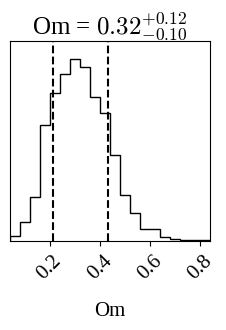

In [31]:
fig = corner.corner(samples_eq_H0, labels=labels_H0, levels=[0.68,0.95], quantiles=[0.16, 0.84], 
                    show_titles=True)

In [32]:
quantiles_H0 = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights_H0)
             for samps in samples_H0.T]
for q,l in zip(quantiles_H0,labels_H0):
    low,med,up=q
    print(l,"=",str(round(med,2)),"+",str(round(up-med,2)),"-",str(round(med-low,2)))

Om = 0.32 + 0.2 - 0.15


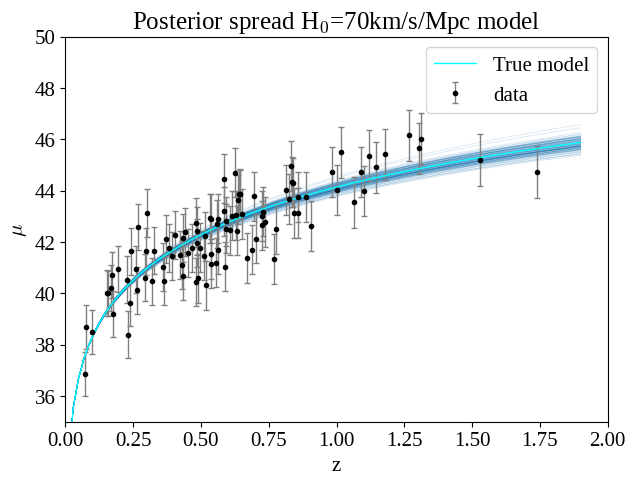

In [33]:
sample100_H0 = samples_eq_H0[np.random.choice(range(len(samples_eq_H0)), 100)]

zgrid = np.linspace(0.01,1.9,100)

for Om in sample100_H0:
    model_spread_H0 = model_H0(70, float(Om), zgrid)
    plt.plot(zgrid, model_spread_H0, alpha=0.2, color='C0', lw=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Posterior spread H$_0$=70km/s/Mpc model')
plt.plot(zgrid, true_model, c='Cyan', lw=1, label='True model')
plt.legend()
plt.show()

If we are able to constrain one parameter, we can achieve better results in the estimation of the other parameter, in this case we decreased the error in $\Omega_m$.

### Clone some data

Starting from the different results obtained, let's generate $N$ new data.

In [39]:
#clone some data

N=1000

z_clone=np.random.uniform(0.01,2.5,N)
mu_model=[]
mu_gpr=[]
mu_noDE=[]
for z in z_clone:
    par = samples_eq[np.random.choice(samples_eq.shape[0])]
    mu_model.append(model(par, z))
    
    par_noDE = samples_eq_noDE[np.random.choice(samples_eq_noDE.shape[0])]
    mu_noDE.append(model_noDE(par_noDE[0], 1, z))
    
    mu_fit, sigma = gaussian_process.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

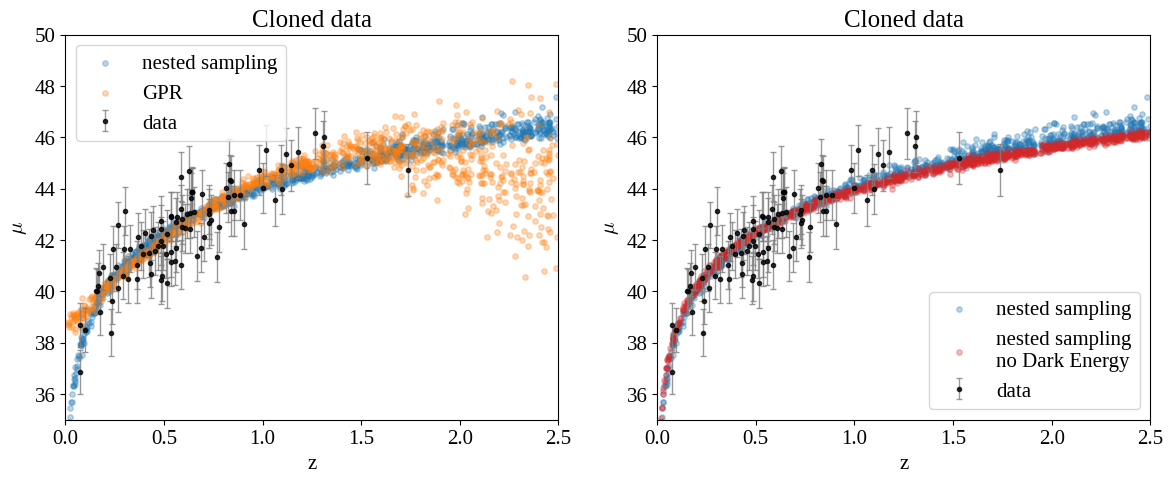

In [42]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.8, label='data')

plt.scatter(z_clone,mu_model,alpha=0.3, s=15,label="nested sampling")
plt.scatter(z_clone,mu_gpr,alpha=0.3, s=15, label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2.5)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend(loc='upper left')

ax = fig.add_subplot(122)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=2, lw=1, alpha=0.8, label='data')

plt.scatter(z_clone,mu_model,alpha=0.3, s=15,label="nested sampling")
plt.scatter(z_clone,mu_noDE,alpha=0.3, s=15, label='nested sampling\nno Dark Energy', color='C3')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2.5)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend(loc='lower right')

plt.show()

The data generated from the Gaussian Process Regression result present, as we expect, an increasing variance as the redshift increases. This because the variance of the fit presents this trend. If we instead consider the data generated starting from the nested sampling resuts, where we fit a model, they present a smaller spread.